In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

import torch

import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

c:\Users\30694\Desktop\DTU\MBML\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [148]:
def get_data_for_component(data, component):
    cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4', component]

    return data[cols]

In [149]:
data_path = Path('../data/processed/data_processed.csv')

data = pd.read_csv(data_path.as_posix())

In [150]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [151]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [152]:
data['datetime'] = pd.to_datetime(data['datetime'])

Try linear regression with one target variable each time, the continuous variable `comp<i>_life` where i in (1,4)

In [158]:
data_comp = []

for i in (1,4):
    i_str = str(i)
    comp_string = "comp" + i_str + "_life"
    data_comp.append(get_data_for_component(data, comp_string))

In [159]:
print(data_comp)

[        voltmean_3h  rotatemean_3h  pressuremean_3h  vibrationmean_3h  \
17       166.281848     453.787824       106.187582         51.990080   
18       175.412103     445.450581       100.887363         54.251534   
19       157.347716     451.882075       101.289380         48.602686   
20       176.450550     446.033068        84.521555         47.638836   
21       190.325814     422.692565       107.393234         49.552856   
...             ...            ...              ...               ...   
290432   193.559926     420.316330       103.020073         46.806359   
290433   190.155535     453.987525       101.459339         40.371431   
290434   194.653945     455.422213        88.315789         36.966571   
290435   201.370850     446.919183       102.771563         43.150286   
290436   182.970445     434.754067        99.459691         41.204898   

        voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  voltmean_24h  \
17      24.276228    23.621315      11.1767

In [162]:
X = data_comp[1].to_numpy()

# Keep the last column as target y
y = X[:,-1]
X = X[:,:-1]

In [163]:
def model(X, obs=None):
    
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                              # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                              # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
      
    return y

Scaling or Normalizing our data by substracting the mean value and dividing with the std.

In [164]:
X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc = train_test_split(X, y, test_size=0.2, random_state=0)

In [165]:
X_mean = X_train_unsc.mean(axis=0)
X_std = X_train_unsc.std(axis=0)

y_std = y_train_unsc.std()
y_mean = y_train_unsc.mean()

In [166]:
X_train = (X_train_unsc - X_mean)/ X_std
X_test = (X_test_unsc - X_mean)/X_std

y_train = (y_train_unsc- y_mean)/ y_std 
y_test = (y_test_unsc- y_mean)/y_std

In [167]:
# # Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [168]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_torch, y_train_torch)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [1:11:11,  3.56s/it, step size=3.10e-02, acc. prob=0.925]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.01      0.00     -0.02      0.02   1547.29      1.00
   beta[0]     -0.01      0.02     -0.01     -0.04      0.03   1587.86      1.00
   beta[1]     -0.03      0.02     -0.03     -0.07      0.01    922.64      1.00
   beta[2]     -0.04      0.03     -0.05     -0.09      0.00   1432.29      1.00
   beta[3]     -0.06      0.03     -0.06     -0.10     -0.01   1123.17      1.00
   beta[4]     -0.01      0.01     -0.01     -0.03      0.02   1702.64      1.00
   beta[5]     -0.02      0.02     -0.02     -0.05      0.00   1924.91      1.00
   beta[6]      0.03      0.01      0.03      0.01      0.05   2318.79      1.00
   beta[7]      0.01      0.01      0.01     -0.01      0.04   1488.57      1.00
   beta[8]      0.04      0.03      0.04     -0.01      0.09   1172.16      1.00
   beta[9]      0.11      0.04      0.11      0.05      0.16   1073.26      1.00
  beta[10]     -0.03      0

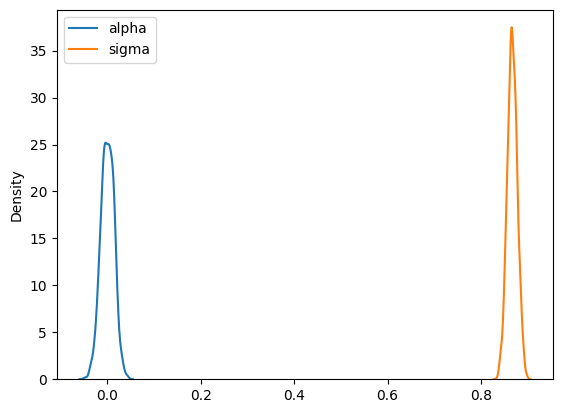

In [169]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["alpha"])
sns.kdeplot(posterior_samples["sigma"])

# Alternative
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
#plt.axis([-2,2,0,5])
plt.show()

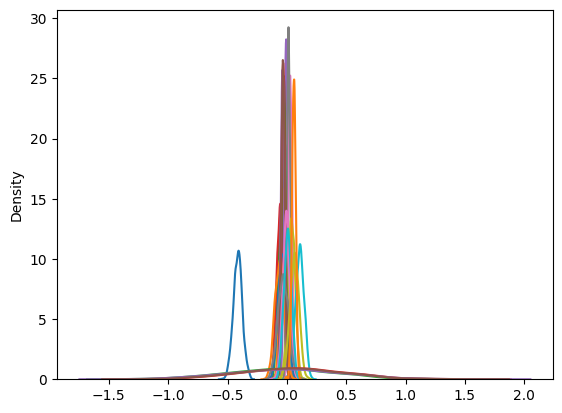

In [170]:
for i in range(X.shape[1]):
    sns.kdeplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    #sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

#plt.legend(["b%d" % i for i in range(X.shape[1])])
#plt.axis([-2,2,0,5])
plt.show()

In [171]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)
y_hat_train = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_train, posterior_samples["beta"].numpy().T), axis=1)

In [172]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [173]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
preds_train = y_hat_train * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.460
MAE: 22.439
RMSE: 34.749
R2: 0.211


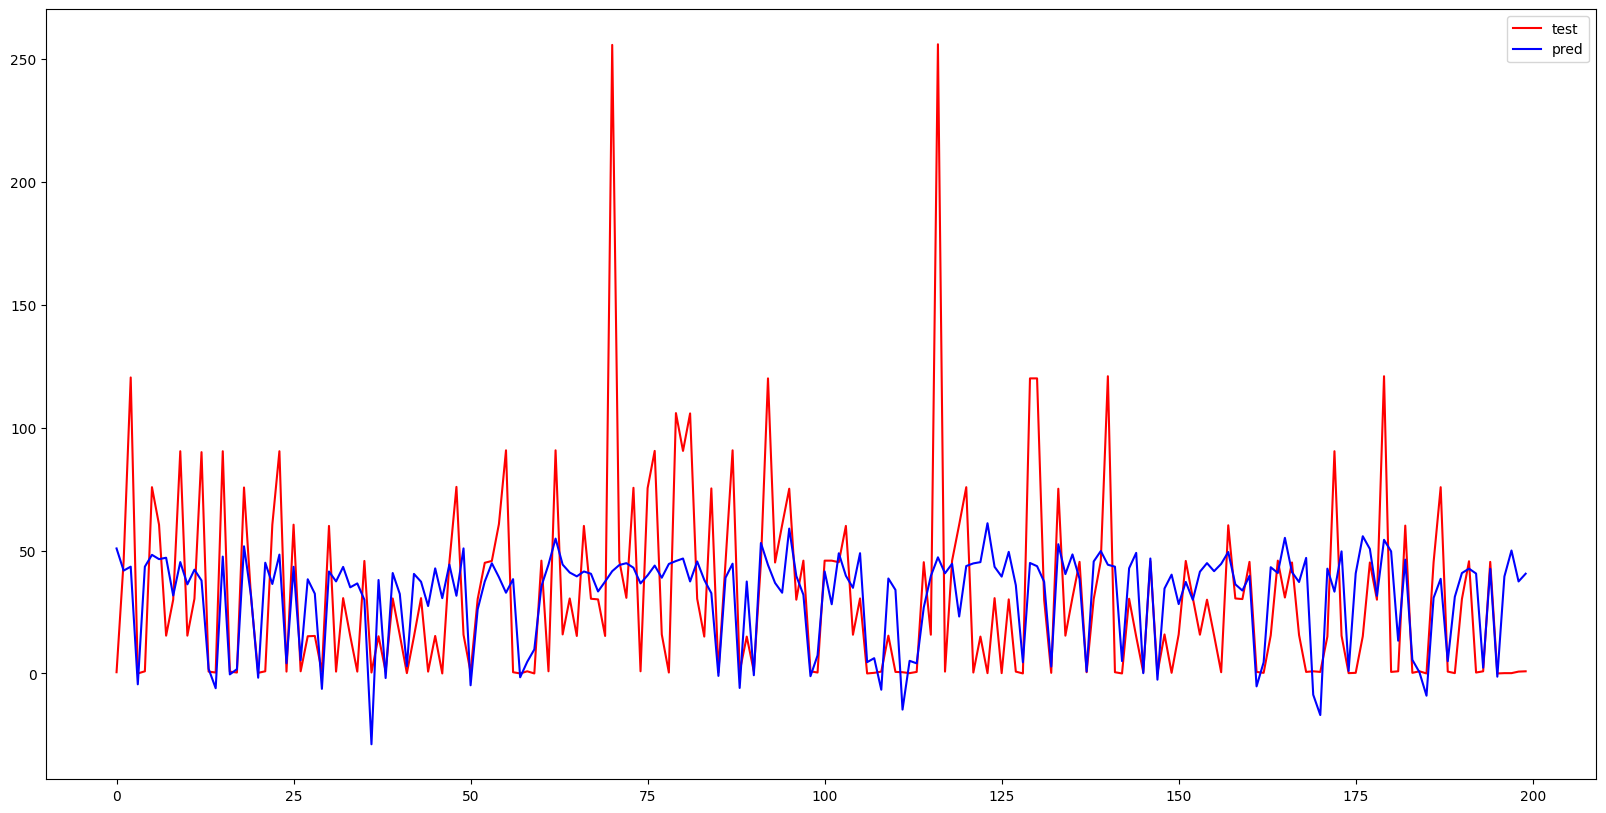

In [174]:
fig = plt.figure(figsize=(20,10))

start = 400
end = 600

plt.plot(y_test_unsc[start:end], 'r-', label = 'test')
plt.plot(preds[start:end], 'b-', label = 'pred')

plt.legend()

plt.show()


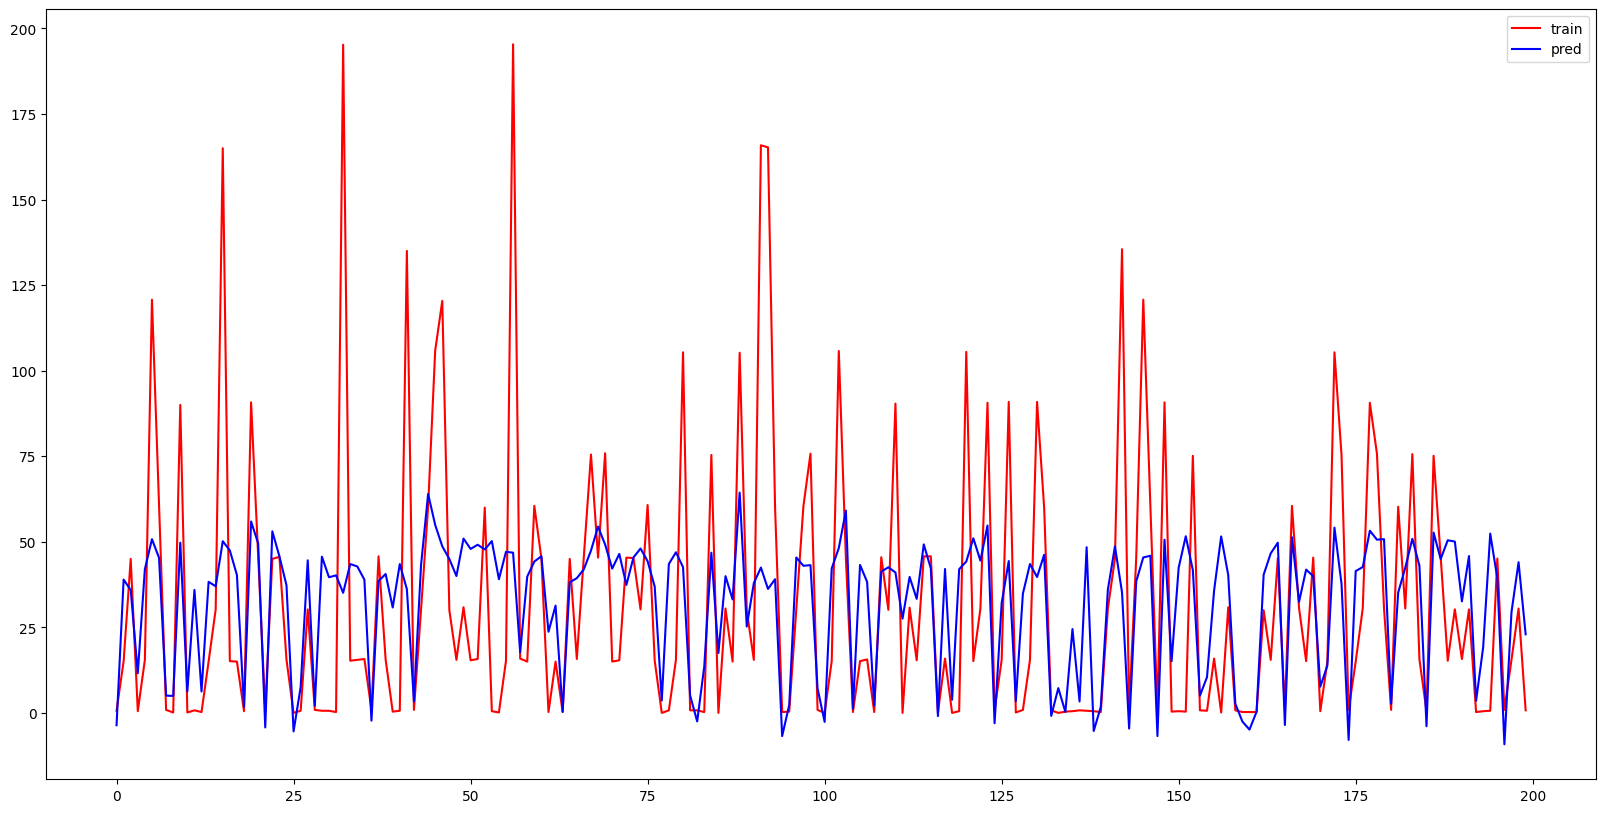

In [144]:
fig = plt.figure(figsize=(20,10))

start = 400
end = 600

plt.plot(y_train_unsc[start:end], 'r-', label = 'train')
plt.plot(preds_train[start:end], 'b-', label = 'pred')

plt.legend()

plt.show()